# Algorithmic Fairness, Accountability, and Ethics, Spring 2024
# Exercise 4

## Task 0 (Setup)

We use the same dataset as in week 2 and 3. If you missed to install the module, please carry out the installation tasks at <https://github.com/zykls/folktables#basic-installation-instructions>.

After successful installation, you should be able to run the following code to generate a prediction task.
To make your life easier, we made the `BasicProblem`-magic from the `folktables` package (see exercises of week 2) explicit in this task.
This way, you can get access to different encodings of the data. 

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lime import lime_tabular


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 25000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

In [2]:
# Set up using categorical data for RF
cols = data_original.columns

cols = cols[:-2]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data_original[cols], target, group, test_size=0.2, random_state=0)

X_train.loc[X_train.ENG.isna(), 'ENG'] = 0 # Fill missing values with 0, shap gets upset with NaNs
X_test.loc[X_test.ENG.isna(), 'ENG'] = 0

# Task

1. Train a black-box model classifier (for example, use a random forest, a gradient-boosted decision tree, an SVM, or a Neural Network). Report on its accuracy. If you have used a tree data structure such as RF or gradient-boosted decision trees, report on the feature importance.



In [3]:
#Gonna scale the AGEP column this time...
scaler = ColumnTransformer(
    [('scaler', MinMaxScaler(),['AGEP'])], 
    remainder='passthrough')

scaler.fit(X_train) #Make sure we fit to the training data only, to avoid data leakage
X_train.AGEP = scaler.transform(X_train)[:,0]
X_test.AGEP = scaler.transform(X_test)[:,0]

clf = RandomForestClassifier(max_depth=5, 
                             random_state=23, 
                             n_jobs=-1, 
                             n_estimators=20) #I probably want more estimators really

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.7888738404926788

In [4]:
sorted([x for x in zip(clf.feature_names_in_, clf.feature_importances_)], key=lambda x: x[1], reverse=True)

[('AGEP', np.float64(0.40802168878904704)),
 ('HINS1', np.float64(0.1865304419639952)),
 ('HINS4', np.float64(0.12012424885882758)),
 ('SCHL', np.float64(0.10070738974780671)),
 ('MAR', np.float64(0.09904676365337045)),
 ('ENG', np.float64(0.031647308048616915)),
 ('SEX', np.float64(0.029458743800168292)),
 ('HINS2', np.float64(0.007259194116687487)),
 ('CIT', np.float64(0.007115729688334229)),
 ('COW', np.float64(0.006068568986357068)),
 ('RAC1P', np.float64(0.004019922346789066))]

This gives us some idea of how important each feature is to the output, but isn't super useful. I used categorical features this time, so whilst SCHL is the second highest feature, it doesn't tell me if any particular value is important.

2. Use the `shap` module to explain predictions on your black-box model. Do the same with a white-box model that you have trained during last week's exercises. Contrast the two models to each other: What are similarities, how do they differ? As shown in the lecture, provide a summary plot, a dependence plot,  a  force plot for a negatively/positively predicted feature vector, and summary plot on the interaction values.

In [5]:
explainer = shap.TreeExplainer(clf, X_train, model_output='probability')
shap_values = explainer(X_test)

 98%|===================| 76716/78266 [00:37<00:00]        

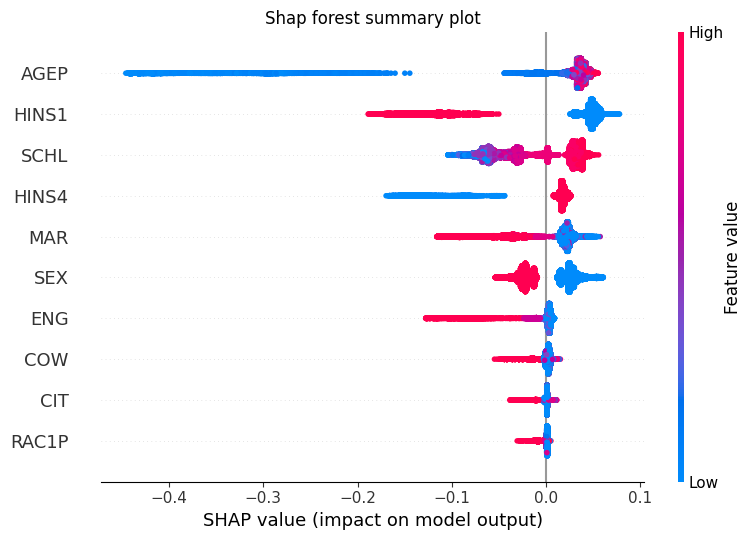

In [6]:
## Summary plot
shap.summary_plot(shap_values[:,:,1], X_test, 
                  feature_names=X_train.columns, 
                  max_display=10, show=False)

plt.title(f'Shap forest summary plot')
plt.tight_layout()

plt.show()

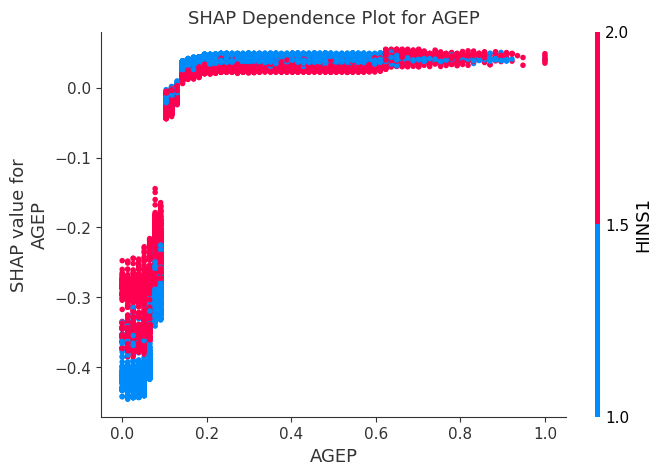

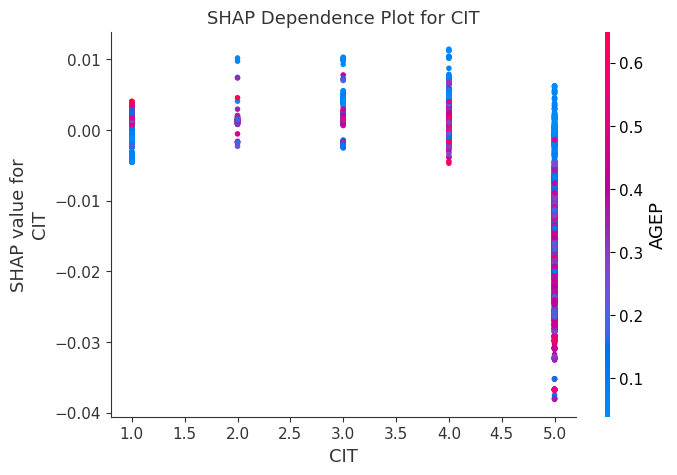

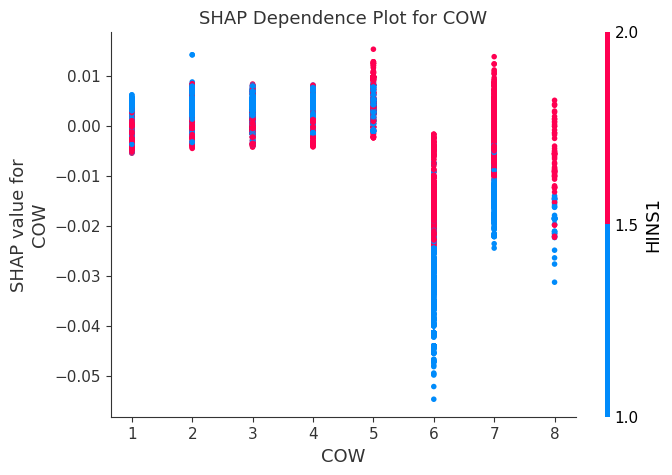

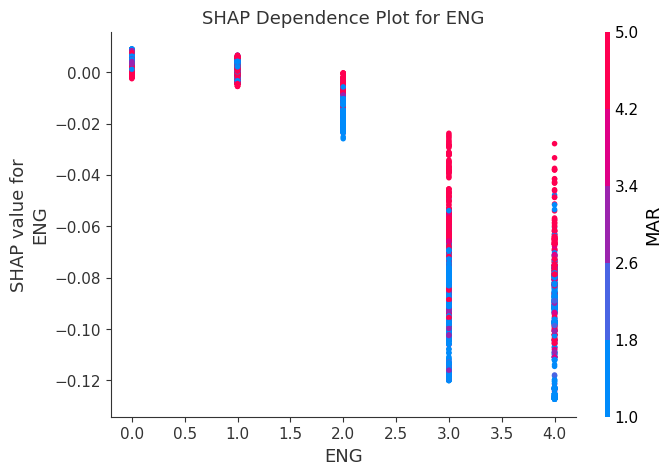

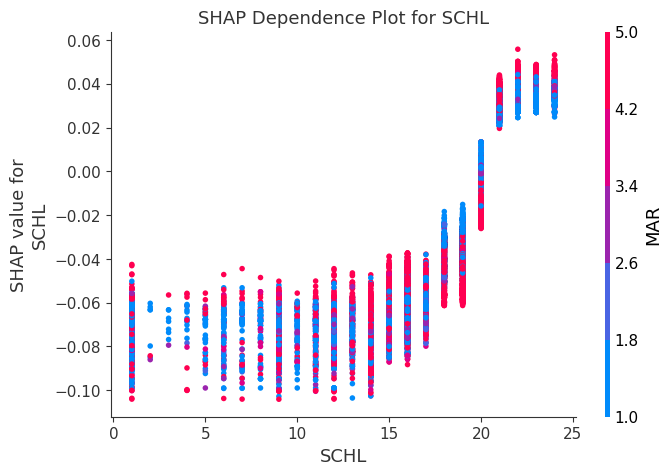

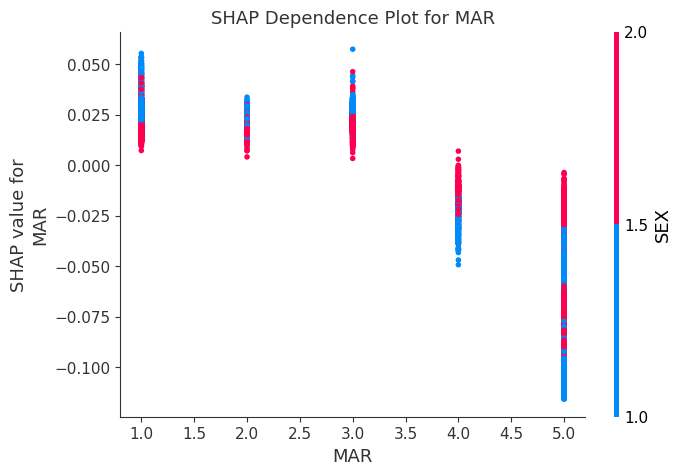

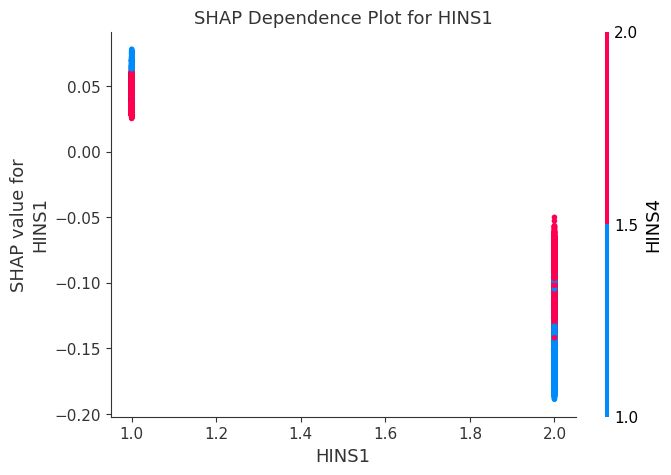

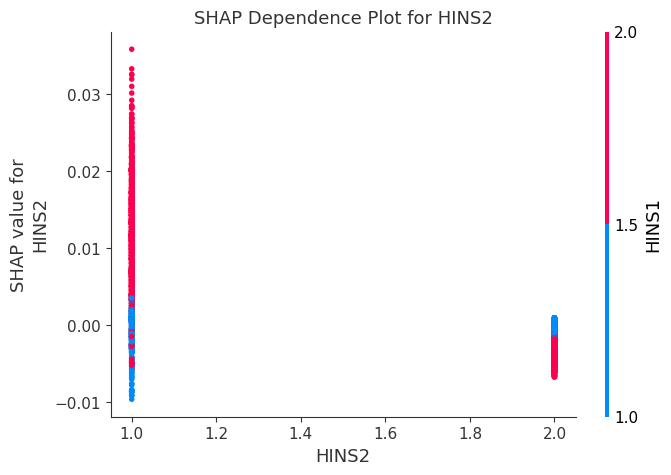

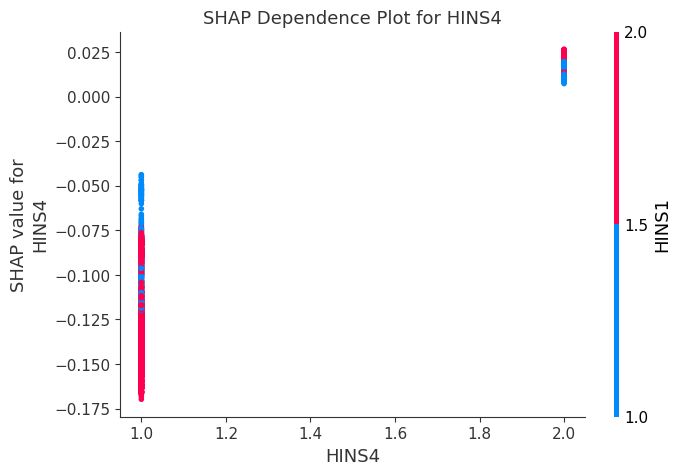

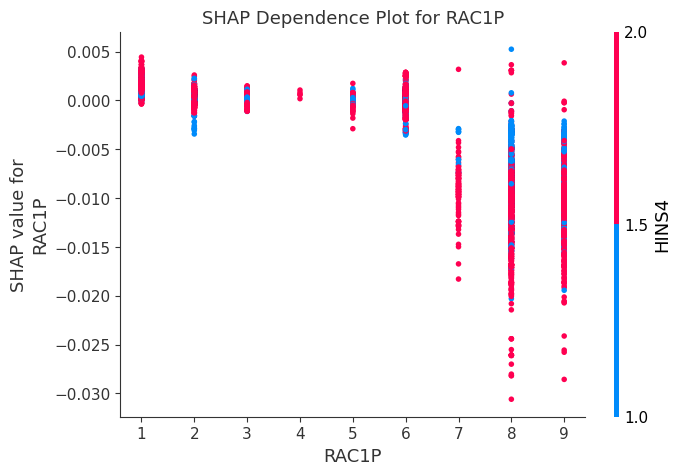

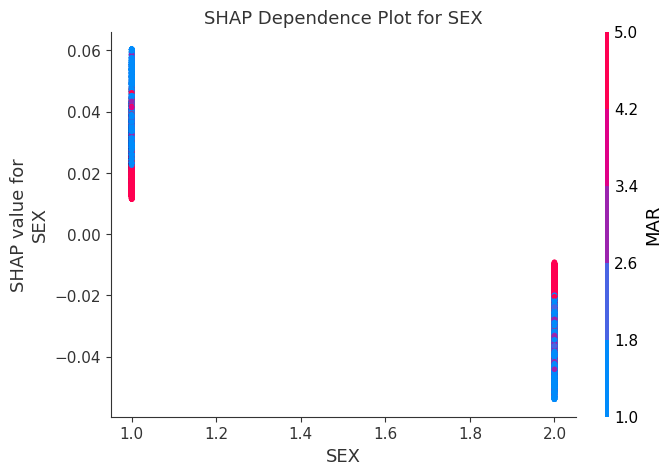

In [7]:
#dependence plots
for name in X_train.columns:
    shap.dependence_plot(name, shap_values.values[:,:,1], 
                         X_test, title=f'SHAP Dependence Plot for {name}')

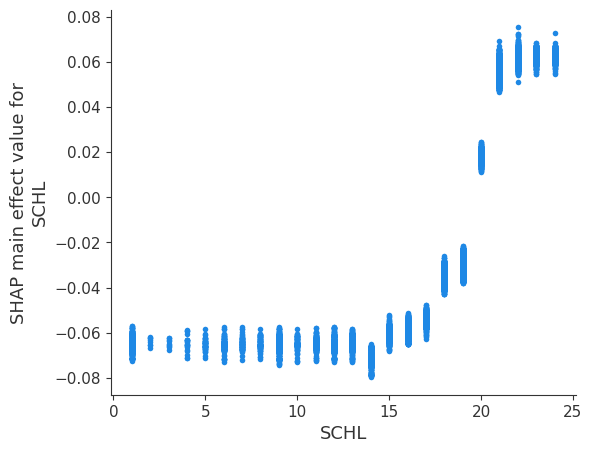

In [8]:
#interaction plot
explainer2 = shap.TreeExplainer(model=clf) #If we don't get output for probabilities, we can look at the interaction values
shap_interaction_values = explainer2.shap_interaction_values(X_train)

shap.dependence_plot(('SCHL', 'SCHL'), 
                     shap_values=explainer2.shap_interaction_values(X_test)[:,:,:,1], 
                     features=X_test, title='SHAP Interaction Plot for SCHL'); 


Predicted probability of positive class: 0.49999, so classified to False
Actual class: False


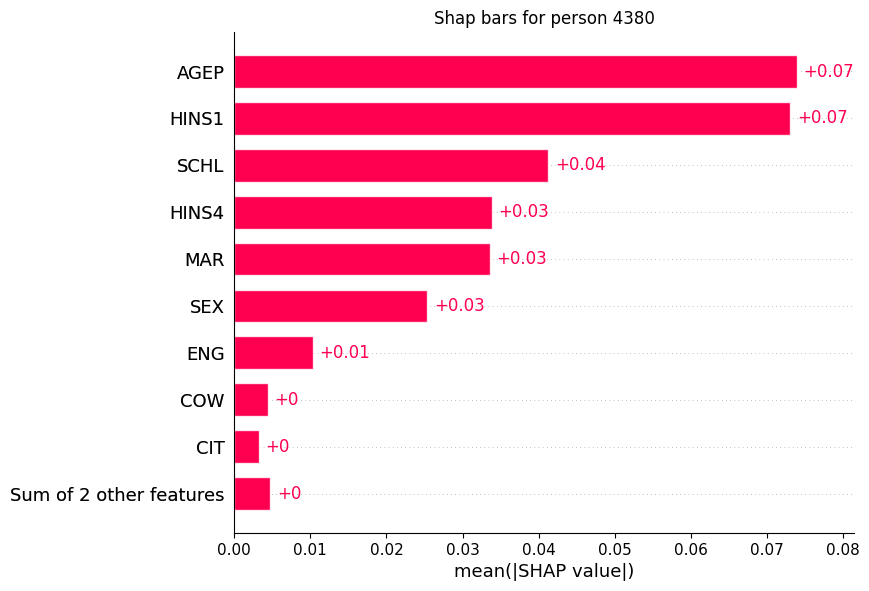

In [9]:
probs = clf.predict_proba(X_test)[:,0]
dp = np.argmin(abs(probs-0.5))

p = clf.predict_proba(pd.DataFrame(X_test.iloc[dp]).T)[0,1]
print(f'Predicted probability of positive class: {p:.5f}, so classified to {"True" if p >=0.5 else "False"}')
print(f'Actual class: {y_test[dp]}')

shap.plots.bar(shap_values[dp:,:,1], show=False)
plt.title(f'Shap bars for person {dp}');

In [10]:
shap.initjs() #need this to display the force plot

cl = 1 #either class 0 or class 1, we can explain either way
shap.force_plot(explainer.expected_value[cl], shap_values[dp,:,cl].values, feature_names=X_train.columns) 

### LIME example
from: https://www.geeksforgeeks.org/introduction-to-explainable-aixai-using-lime/

For comparison, lets compare LIME explanations for the same data point

In [11]:
explainer_lime = lime_tabular.LimeTabularExplainer(X_train.to_numpy(),
                                                   feature_names=X_train.columns,
                                                   categorical_features=[i for i in X_train.columns if "AGEP" not in i],
                                                   verbose=True,
                                                   mode='classification')

In [12]:
exp_lime = explainer_lime.explain_instance(X_test.iloc[dp], clf.predict_proba)
 
# Finally visualizing the explanations
exp_lime.show_in_notebook()

Intercept 0.8236799870315524
Prediction_local [0.32776014]
Right: 0.49999087574399503


/home/xannadoo/miniconda3/envs/AFAE/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/xannadoo/miniconda3/envs/AFAE/lib/python3.11/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/xannadoo/miniconda3/envs/AFAE/lib/python3.11/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (co

3. Reflect on the explanations: How does the white box models's (from last week) black-box explanation relate to its white-box explanation? Which classifier would you prefer when deploying a model as part of the machine learning pipeline? 